# 1. Low level features

In [71]:
import numpy as np
import pandas as pd
from scipy import signal
import pickle
import importlib
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import librosa
import librosa.display

import util

## 1.2 Explore frequency-domain features

In [48]:
file = 'b02'
fs_new = 2.4
b, a = signal.butter(3, 0.1)

with open('features/HR_' + file + '.pkl', 'rb') as f:
    data = pickle.load(f)

with open('data/processed/' + file + '.pkl', 'rb') as f:
    apn = pickle.load(f)['apn']
    group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper()   

# Remove outliers    
idx_valid = (data['hr'] < 2) & (data['hr'] > 0.5)
hr_raw, t_raw = data['hr'][idx_valid], data['t'][idx_valid]

# Smooth data
hr_raw = signal.filtfilt(b, a, hr_raw)

# Resample data for frequency-domain analysis
t = np.arange(t_raw[0], t_raw[-1], 1 / fs_new / 60)
hr = np.interp(t, t_raw, hr_raw)

minute = 0
idx = (t > minute) & (t < minute + 5)

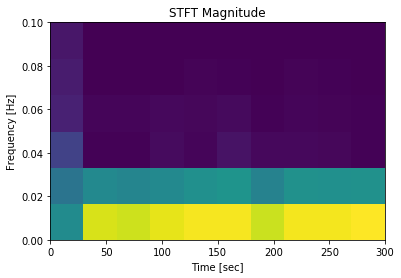

In [49]:
# STFT
f, t_stft, Zxx = signal.stft(
    hr[idx], fs=fs_new, window='hann', 
    nperseg=24*6, noverlap=None, nfft=None, detrend=False, 
    return_onesided=True, boundary='zeros', padded=True)
plt.pcolormesh(t_stft, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0, 0.1])
plt.show()

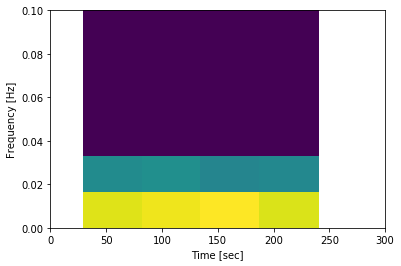

In [51]:
# spectrogram
f, t_sg, Sxx = signal.spectrogram(
    hr[idx], fs=fs_new,
    window='hann', nperseg=24*6, noverlap=None, 
    nfft=None, detrend=False, return_onesided=True, 
    scaling='density', mode='psd')
plt.pcolormesh(t_sg, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.xlim([0, 300])
plt.ylim([0, 0.1])
plt.show()

(40, 145)


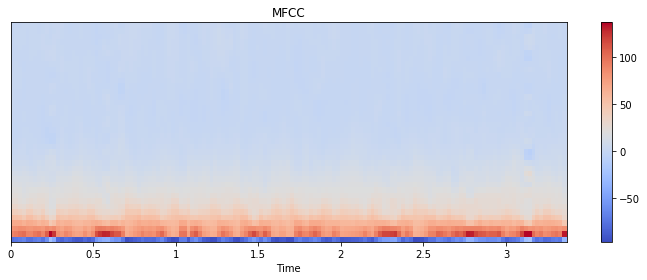

In [86]:
# MFCC
mfccs = librosa.feature.mfcc(y=hr, sr=fs_new, n_mfcc=40)
print(mfccs.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
# plt.xlim([0, 5])
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

## 1.3 Wavelet spectrogram

In [17]:
# Spectrogram
def get_cwt(file, fs_new=1, smooth=True, cwt_width=100, return_segments=False, segment_window=3, diagPlot=False, xlm=[0, 10]):
    # Input
    # segment_window: Window size in minutes to associate with labels
    # xlm: Xlim for diagnostic plot in minutes
    
    b, a = signal.butter(3, 0.1)

    with open('features/HR_' + file + '.pkl', 'rb') as f:
        data = pickle.load(f)

    with open('data/processed/' + file + '.pkl', 'rb') as f:
        apn = pickle.load(f)['apn']
        group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper()   

    # Remove outliers    
    idx_valid = (data['hr'] < 2) & (data['hr'] > 0.5)
    hr_raw, t_raw = data['hr'][idx_valid], data['t'][idx_valid]

    # Smooth data
    if smooth:
        hr_raw = signal.filtfilt(b, a, hr_raw)

    # Resample data for frequency-domain analysis
    t = np.arange(t_raw[0], t_raw[-1], 1 / fs_new / 60)
    hr = np.interp(t, t_raw, hr_raw)

    widths = np.arange(1, cwt_width + 1)
    cwt = signal.cwt(hr, signal.ricker, widths)
    
    # Diagnose plot
    if diagPlot:
        fig = plt.figure(figsize=(20,10))
        # Time history plot
        fig.add_subplot(2, 1, 2)
        plt.plot(t, hr)
        plt.xlim(xlm)

        # Wavelet plot
        fig.add_subplot(2, 1, 1)
        plt.imshow(cwt, cmap='PRGn', aspect='auto', origin='lower')
        for minute in range(len(apn)):
            sym = 'r-' if apn[minute] else 'g-'
            plt.plot(np.array([minute, minute+1]) * 60 * fs_new, [0, 0], sym, linewidth=5)

        plt.xlim(np.array(xlm) * 60 * fs_new)
        plt.xticks([])
        plt.show()
    
    if return_segments:
        half_window = int(segment_window / 2)
        seg_cwtmatr = []
        # Skip first and last 2-minute data to eliminate boundary effects of CWT
        for idx in range(2 + half_window, len(apn) - half_window):
            minute_start = idx - half_window
            idx_start = int(minute_start * 60 * fs_new)
            seg_cwtmatr.append(cwt[:, idx_start : int(idx_start + segment_window * 60 * fs_new)])
        
        cwt = seg_cwtmatr
        apn = apn[2 + half_window : len(apn) - half_window]
        
    return cwt, apn, group

### Record indicating difficulty in high accuracy: b02 hour 3

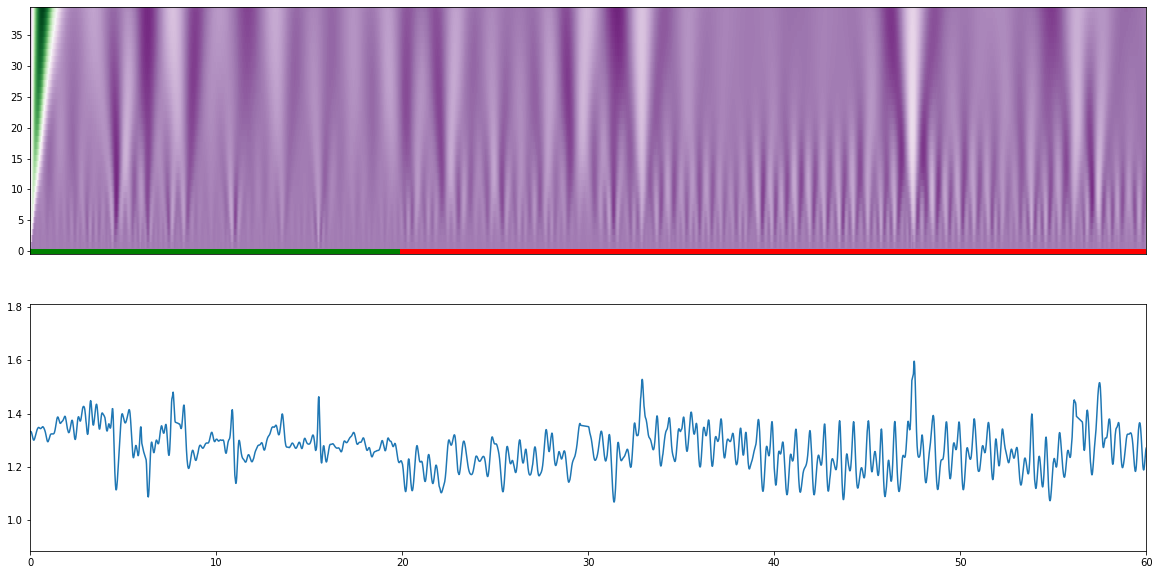

In [12]:
hour = 1
cwt, apn, group = get_cwt(
    file='a02', fs_new=1, smooth=True, cwt_width=40, 
    diagPlot=True, xlm=[60 * (hour - 1), 60 * hour])

### Arrange cwt results for training set

In [18]:
def extract_cwt(file_names):
    df = pd.DataFrame()
    for file in file_names:
        cwt, apn, group = get_cwt(file, fs_new=1, smooth=True, cwt_width=40, 
                                  return_segments=True, segment_window=3)
        df_temp = pd.DataFrame({
            'cwt': cwt,
            'apn': apn, 
            'group': [group] * len(apn),
            'file': [file] * len(apn),
        })
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)
        
    df['apn'] = df['apn'].astype(int)
    return df

In [19]:
train_df = pd.read_csv('resources/File_train.csv')
df = extract_cwt(train_df['file'])
with open('features/cwt_train.pkl', 'wb') as f:
    pickle.dump(df, f)

-2.901585447569937 6.3692713766176166


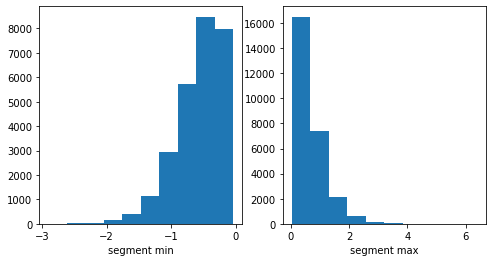

In [20]:
df['min'] = df['cwt'].apply(np.min)
df['max'] = df['cwt'].apply(np.max)

print(np.min(df['min']), np.max(df['max']))

fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.hist(df['min'])
plt.xlabel('segment min')
fig.add_subplot(1, 2, 2)
plt.hist(df['max'])
plt.xlabel('segment max')
plt.show()

### Arrange cwt results for testing set

In [21]:
test_df = pd.read_csv('resources/File_test.csv')
for file in test_df['file']:
    df = extract_cwt([file])
    with open('resources/cwt_' + file + '.pkl', 'wb') as f:
        pickle.dump(df, f)

### Generate image for training set

In [22]:
with open('features/cwt_train.pkl', 'rb') as f:
    df = pickle.load(f)

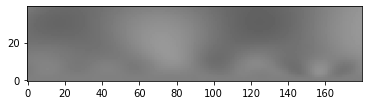

In [38]:
# Sample image
plt.imshow(
    df['cwt'][0], cmap='gray', aspect='equal', origin='lower',
    vmin=-2, vmax=2,
)

In [45]:
df = df.sample(frac=1)
data_folder = '../../../Desktop/Apnea'
total_dict = {'1': sum(df['apn']), '0': sum(1 - df['apn'])}
count_dict = {'1': 0, '0': 0}

# Generate folders
for folder in ['train', 'val']:
    if not os.path.isdir(f'{data_folder}/{folder}'):
        os.mkdir(f'{data_folder}/{folder}')
    for subfolder in ['0', '1']:
        if not os.path.isdir(f'{data_folder}/{folder}/{subfolder}'):
            os.mkdir(f'{data_folder}/{folder}/{subfolder}')
            
# Generate images (80% for training and 20% for validation)
for index, row in df.iterrows():
    apn = str(row['apn'])
    folder = 'train' if (count_dict[apn] < total_dict[apn] * 0.8) else 'val'
    count_dict[apn] += 1
    subfolder = '1' if row['apn'] else '0'
    plt.imsave(
        f'{data_folder}/{folder}/{subfolder}/{index}.png', row['cwt'], 
        cmap='gray', origin='lower',
        vmin=-2, vmax=2,
    )

### Generate image for testing set

In [46]:
test_df = pd.read_csv('resources/File_test.csv')
for file in test_df['file']:
    with open(f'features/cwt_{file}.pkl', 'rb') as f:
        df = pickle.load(f)
    
    if not os.path.isdir(f'{data_folder}/test'):
        os.mkdir(f'{data_folder}/test')
    if not os.path.isdir(f'{data_folder}/test/{file}'):
        os.mkdir(f'{data_folder}/test/{file}')
    for subfolder in ['0', '1']:
        if not os.path.isdir(f'{data_folder}/test/{file}/{subfolder}'):
            os.mkdir(f'{data_folder}/test/{file}/{subfolder}')  
            
    for index, row in df.iterrows():
        subfolder = '1' if row['apn'] else '0'
        plt.imsave(
            f'{data_folder}/test/{file}/{subfolder}/{index}.png', row['cwt'], 
            cmap='gray', origin='lower',
            vmin=-2, vmax=2,
        )

# 2. High level features for model fitting

In [2]:
from hrvanalysis import get_time_domain_features, get_csi_cvi_features
import numpy as np
import pandas as pd
import pickle
from scipy import signal

import util

In [3]:
def extract_features(file_names):
    df = pd.DataFrame()
    b, a = signal.butter(3, 0.1)
    fs_new = 2.4 # optimized from hyper-parameter tuning

    for file in file_names:
        print(file)
        
        # Load files
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']
            group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute
            
        # Remove outliers 
        idx_valid = (hr < 2) & (hr > 0.5)
        hr, t_hr = hr[idx_valid], t_hr[idx_valid]
        
        # Filter out high-frequency noise
        hr_smth = signal.filtfilt(b, a, hr)
        
        # Resample data for frequency-domain analysis
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)
        
        # Extract features from each segment
        for minute in range(len(apn) - 4):
            fea_dict = {}
            idx_1min = (t_hr > minute + 2) & (t_hr < minute + 3)
            idx_5min = (t_hr > minute) & (t_hr < minute + 5)
            data_1min, data_5min = hr_smth[idx_1min], hr_smth[idx_5min]
            
            hr_interp_1min = hr_interp[(t_interp > minute + 2) & (t_interp < minute + 3)]
            hr_interp_5min = hr_interp[(t_interp > minute) & (t_interp < minute + 5)]
            
            # Discard segment if less than 30 heart beats detected
            if len(data_1min) < 30: 
                continue
                
            # Time-domain features for data_1min
            md = np.median(data_1min)
            fea_dict.update({
                'md_1min': md,
                'min_r_1min': data_1min.min() - md,
                'max_r_1min': data_1min.max() - md,
                'p25_r_1min': np.percentile(data_1min, 0.25) - md,
                'p75_r_1min': np.percentile(data_1min, 0.75) - md,
                'mean_r_1min': data_1min.mean() - md,
                'std_1min': data_1min.std(),
                'acf1_1min': pd.Series(hr_interp_1min).autocorr(12),
                'acf2_1min': pd.Series(hr_interp_1min).autocorr(24),
            })
            
            # Time-domain features for data_5min
            md = np.median(data_5min)
            fea_dict.update({
                'md_5min': md,
                'min_r_5min': data_5min.min() - md,
                'max_r_5min': data_5min.max() - md,
                'p25_r_5min': np.percentile(data_5min, 0.25) - md,
                'p75_r_5min': np.percentile(data_5min, 0.75) - md,
                'mean_r_5min': data_5min.mean() - md,
                'std_5min': data_5min.std(),
                'acf1_5min': pd.Series(hr_interp_5min).autocorr(12),
                'acf2_5min': pd.Series(hr_interp_5min).autocorr(24),
            })
            
            # Heart rate variability
            nn_intervals = (np.diff(t_hr[idx_1min]) * 1000 * 60).astype(int) # Unit in ms
            time_domain_features = get_time_domain_features(nn_intervals)
            nonlinear_features = get_csi_cvi_features(nn_intervals)
            fea_dict.update(time_domain_features)
            fea_dict.update(nonlinear_features)
            
            # Frequency-domain features
            freqs, psd = signal.welch(
                x=hr_interp_5min, 
                fs=fs_new)
            fea_dict.update({
                'peak': psd.max(),
                'f_peak': freqs[np.argmax(psd)],
                'area_total': psd.sum(),
                'area_lf': psd[freqs < 1e-2].sum(),
                'area_hf': psd[freqs > 1e-2].sum(),
                'area_ratio': psd[freqs > 1e-2].sum() / psd[freqs < 1e-2].sum(),
            })
            
            # Label information
            fea_dict.update({
                'apn': apn[minute + 2],
                'group': group,
                'file': file,
            })
            df = df.append(fea_dict, ignore_index=True)
                    
    df['apn'] = df['apn'].astype(int)
    return df

In [4]:
train_df = pd.read_csv('resources/File_train.csv')
df = extract_features(train_df['file'])
df.dropna(inplace=True)
df.to_csv('features/feature_train.csv', index=False)

x32
a13
c09
x29
b02
c03
x16
a08
a15
x34
a14
a12
a07
c05
a04
a06
x28
a09
b01
x33
c10
c04
a16
x20
a10
a19
x27
x01
x07
x19
a17
b05
x18
b04
x11
x17
a05
x22
x35
x31
x13
a01
c02
x24
x21
x02
x08
x09
x14
b03
c08
a11
a02
x30
x12
c07


In [9]:
test_df = pd.read_csv('resources/File_test.csv')
for file in test_df['file']:
    df = extract_features([file])
    df.dropna(inplace=True)
    df.to_csv('resources/feature_' + file + '.csv', index=False)

x03
x23
x05
x26
c01
x04
x10
x06
c06
x25
x15
a03
a18
a20


# z_3. Spectrum for MLP

In [ ]:
def extract_spectrum(file_names):
    df = pd.DataFrame()
    b, a = signal.butter(3, 0.1)
    fs_new = 2.4 # optimized from hyper-parameter tuning
    fea = []

    for file in file_names:
        # Load files
        with open('data/processed/' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            apn = res['apn']
            group = util.ecg_diagnose(apn) if file[0] == 'x' else file[0].upper() 

        with open('features/HR_' + file + '.pkl', 'rb') as f:
            res = pickle.load(f)
            hr = res['hr']
            t_hr = res['t'] # in minute
            
        # Remove outliers 
        idx_valid = (hr < 2) & (hr > 0.5)
        hr, t_hr = hr[idx_valid], t_hr[idx_valid]
        
        # Filter out high-frequency noise
        hr_smth = signal.filtfilt(b, a, hr)
        
        # Resample data for frequency-domain analysis
        t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
        hr_interp = np.interp(t_interp, t_hr, hr_smth)
        
        # Extract features from each segment
        for minute in range(len(apn) - 4):
            idx_5min = (t_hr > minute) & (t_hr < minute + 5)
            data_5min = hr_smth[idx_5min]
            
            # Discard segment if less than 30 heart beats detected
            if len(data_5min) < 30: 
                continue
                
            # Frequency-domain features
            freqs, psd = signal.welch(
                x=hr_interp[(t_interp > minute) & (t_interp < minute + 5)], 
                fs=fs_new)
            fea.append([
                psd.max(), freqs[np.argmax(psd)], 
                psd[freqs < 1e-2].sum(), psd[freqs > 1e-2].sum(), 
                psd[freqs > 1e-2].sum() / psd[freqs < 1e-2].sum(),
                *psd[freqs < 0.1], 
            ])
            # Label information
            df = df.append({
                'apn': apn[minute + 2],
                'group': group,
                'file': file,
            }, ignore_index=True)
                    
    df['apn'] = df['apn'].astype(int)
    fea = np.vstack(fea)
    df = pd.concat([df, pd.DataFrame(fea)], axis=1)
    return df

In [ ]:
train_df = pd.read_csv('resources\File_train.csv')
df = extract_spectrum(train_df['file'])
df.to_csv('features/mlp.csv', index=False)